In [1]:
import torch
import numpy
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def Cliff2():
    """
    Random 2-qubit Clifford circuit.

    Arguments:
        -nodes (np.ndarray): 
    
    Returns:
        -null
    """
    
    weights = np.random.randint(2, size=(2, 10))
    
    return qml.matrix(qml.RandomLayers(weights=weights,wires=[0,1])).numpy()

In [3]:
def RandomLayers(N_QUBITS, DEPTH):
    """
    Generates brick wall pattern of random 2 qubit Clifford gates

    Arguments:
        -N_QUBITS (int): Number of qubits
        -DEPTH (int): Depth of the circuit

    Returns:
        -random_layers (np.ndarray): Array of 4x4 unitaries (N_QUBITS, DEPTH, 4, 4)
    
    """

    random_layers = []
    for t in range(DEPTH):
        layer = []
        for x in range(0,N_QUBITS,2):
                layer.append(Cliff2())
        random_layers.append(layer)

    return random_layers


In [4]:
N_QUBITS = 2*2
DEPTH = 2

# random_layers = []
# # for t in range(DEPTH):
# #         layer = []
# #         for x in range(0,N_QUBITS,2):
# #                 layer.append(Cliff2())
# #         random_layers.append(layer)

random_layers = RandomLayers(N_QUBITS,DEPTH)

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def circuit(theta,random_layers):
    """
    Quantum circuit with random entangling Clifford layers and disentangling layers.
    
    Arguments:
        -theta (np.ndarray): Binary matrix representing the positions of projections. (N_QUBITS, DEPTH)
    
    Returns:
        -Average Von Neumann entropy (float32): Average of 2-qubit Von Neumann entropies over all neighbors.
    """

    theta = theta.T
    DEPTH,N_QUBITS = np.shape(theta)

    for t in range(DEPTH):
        layer = random_layers[t]
        if t%2==0:
            for x in range(0,N_QUBITS,2):
                brick = layer[int(x/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
        elif t%2==1:
            for x in range(1,N_QUBITS-2,2):
                brick = layer[int((x-1)/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
            brick = layer[-1]
            qml.QubitUnitary(brick,wires=[N_QUBITS-1,0])
            
        projections = theta[t]
        for x in range(N_QUBITS):
            if projections[x]==1:
                qml.Projector(state=[0],wires=[x])
            
    entropies = []
    for x in range(N_QUBITS-1):
        entropies.append(qml.vn_entropy(wires=[x,x+1]))
    entropies.append(qml.vn_entropy(wires=[N_QUBITS-1,0]))
        
    return entropies

In [5]:
random_layers[1][0]

array([[-0.78717511+0.05207472j, -0.09573931+0.00677574j,
        -0.34124821+0.39405114j,  0.28311526-0.12864976j],
       [-0.09573931+0.00677574j,  0.7784738 -0.17502173j,
         0.28311526-0.12864976j,  0.50645833-0.03047871j],
       [ 0.32663169-0.4980366j ,  0.04265093-0.10901295j,
         0.13201375+0.69395948j,  0.04592297-0.36118145j],
       [ 0.04265093-0.10901295j, -0.18663887+0.55280829j,
         0.04592297-0.36118145j,  0.33181013-0.63498589j]])

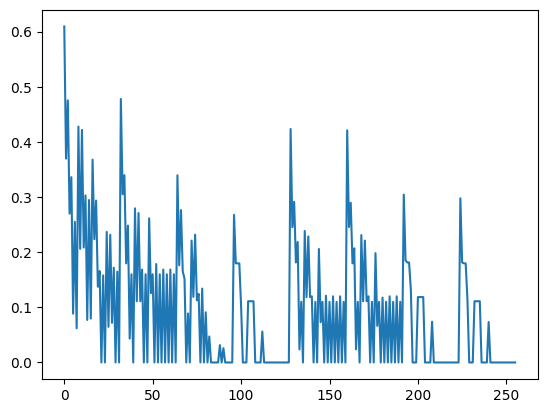

In [6]:
def all_binary_matrices(n, m):
    # Total number of binary matrices possible
    total_matrices = 2 ** (n * m)
    
    # Generate all binary matrices
    matrices = []
    for i in range(total_matrices):
        # Convert i to binary and pad with zeros
        binary_string = format(i, f'0{n*m}b')
        
        # Convert binary string to numpy array and reshape to (n, m)
        matrix = np.array([int(bit) for bit in binary_string]).reshape((n, m))
        matrices.append(matrix)
    
    return np.array(matrices)

x = all_binary_matrices(N_QUBITS,DEPTH)
Y = np.zeros(2**(N_QUBITS*DEPTH))
N = 100
for _ in range(N):
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    y = [np.mean(circuit(theta,random_layers)) for theta in x]
    Y += y
Y = Y/N
plt.plot(Y)

In [7]:
min(Y)

tensor(-2.55351296e-17, requires_grad=True)

In [8]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)

circuit(theta,random_layers)
drawer = qml.draw(circuit)
print(drawer(theta,random_layers))

0: ─╭U(M0)────────────────╭U(M3)─────────┤ ╭vnentropy                       ╭vnentropy
1: ─╰U(M0)──|0⟩⟨0|─╭U(M2)─│──────────────┤ ╰vnentropy ╭vnentropy            │         
2: ─╭U(M1)──|0⟩⟨0|─╰U(M2)─│───────|0⟩⟨0|─┤            ╰vnentropy ╭vnentropy │         
3: ─╰U(M1)────────────────╰U(M3)─────────┤                       ╰vnentropy ╰vnentropy

M0 = 
[[-0.21699216+0.29056468j  0.10418197-0.30490106j -0.27420928+0.75698068j
   0.00378102-0.34123784j]
 [-0.06858102+0.15866803j -0.08151871+0.59015343j -0.10502777+0.42351666j
   0.03528851+0.65080893j]
 [-0.63017659+0.52140727j  0.30834665+0.12320267j  0.2137561 -0.30335254j
  -0.28753261-0.01912926j]
 [-0.33470608+0.23998214j -0.60579307-0.25300849j  0.09592183-0.12031999j
   0.600892  +0.12096603j]]
M1 = 
[[ 0.03196541-0.18866395j -0.32192467-0.14733126j -0.23728233+0.74366963j
  -0.03603751-0.47686058j]
 [-0.11163344-0.08721377j  0.3817932 -0.28797339j  0.40087131+0.41625789j
   0.5898382 +0.26336186j]
 [-0.43248426-0.64984982j  0.284

In [11]:
def loss(theta, random_layers,alpha=1, beta=1.0, gamma=0.5):
    entropy = alpha*np.mean(circuit(theta,random_layers))
    budget = beta*np.mean(np.ndarray.flatten(theta))
    final_layer = gamma*np.mean(theta[:,-1])
    
    return entropy+budget

In [12]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
loss(theta,random_layers)

tensor(0.66385224, requires_grad=True)

In [13]:
def grad(theta,random_layers):
    grads = np.zeros(np.shape(theta))

    for i in range(np.shape(theta)[0]):
        for j in range(np.shape(theta)[1]):
            h = np.zeros(np.shape(theta))
            h[i][j] = 1
            theta_prime = (theta+h)%2
            grads[i][j] = loss(theta_prime,random_layers) - loss(theta,random_layers)
    
    return grads
    

In [14]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)
grad(theta,random_layers)

tensor([[-0.125, -0.125],
        [ 0.125, -0.125],
        [-0.125, -0.125],
        [ 0.125,  0.125]], requires_grad=True)

In [15]:
np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))

(0, 0)

In [16]:
def main():
    n_training = 10
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
    for step in range(n_training):
        l = loss(theta,random_layers)
        entropy = np.mean(circuit(theta,random_layers))
        g = grad(theta,random_layers)
        dir = np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))
        h = np.zeros(np.shape(theta))
        h[dir[0]][dir[1]] = 1
        theta = (theta+h)%2


    return theta, l, entropy


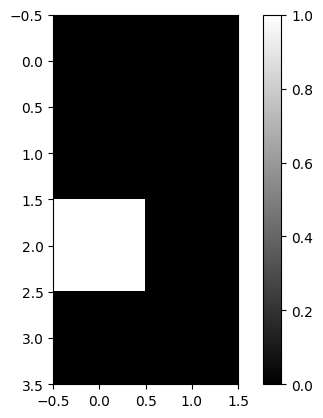


 Loss: 0.2500000000000023, 


In [17]:
theta, l, entropy = main()
plt.imshow(theta, cmap="gray")
plt.colorbar()
plt.show()
print("\n Loss: {}, \n Averaged von Neumann entropy: {}".format(l, entropy), end="\r")

In [18]:
epochs = 10
thetas = []
losses = []
entropies = []
for epoch in range(epochs):
    theta, l, entropy = main()
    thetas.append(theta)
    losses.append(l)
    entropies.append(entropy)

    print("\n Epoch: {}, Loss: {}".format(epoch+1, l), end="\r")


 Epoch: 1, Loss: 0.2877123984134265
 Epoch: 2, Loss: 0.2788210360627681
 Epoch: 3, Loss: 0.29419499169190916
 Epoch: 4, Loss: 0.2567508971508828
 Epoch: 5, Loss: 0.1953392461859107
 Epoch: 6, Loss: 0.353868270050657
 Epoch: 7, Loss: 0.3750000000000002
 Epoch: 8, Loss: 0.2811958419516443
 Epoch: 9, Loss: 0.22868836073161636


In [22]:
thetas

[tensor([[0., 0.],
         [0., 0.],
         [0., 1.],
         [0., 0.]], requires_grad=True),
 tensor([[1., 0.],
         [0., 0.],
         [0., 1.],
         [0., 0.]], requires_grad=True),
 tensor([[0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 0.]], requires_grad=True),
 tensor([[0., 0.],
         [0., 1.],
         [0., 0.],
         [0., 0.]], requires_grad=True),
 tensor([[1., 0.],
         [0., 1.],
         [0., 0.],
         [0., 0.]], requires_grad=True),
 tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 0.]], requires_grad=True),
 tensor([[0., 0.],
         [0., 1.],
         [0., 0.],
         [0., 1.]], requires_grad=True),
 tensor([[0., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.]], requires_grad=True),
 tensor([[0., 0.],
         [0., 1.],
         [1., 0.],
         [0., 0.]], requires_grad=True),
 tensor([[0., 1.],
         [0., 1.],
         [0., 0.],
         [0., 0.]], requires_grad=True)]

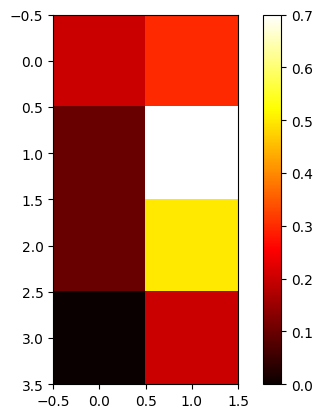

In [24]:
averaged_measurements = np.mean(thetas,axis=0)
plt.imshow(averaged_measurements, cmap="hot")
plt.colorbar()
plt.show()

In [ ]:
for theta in thetas:
    print(circuit(theta,random_layers))

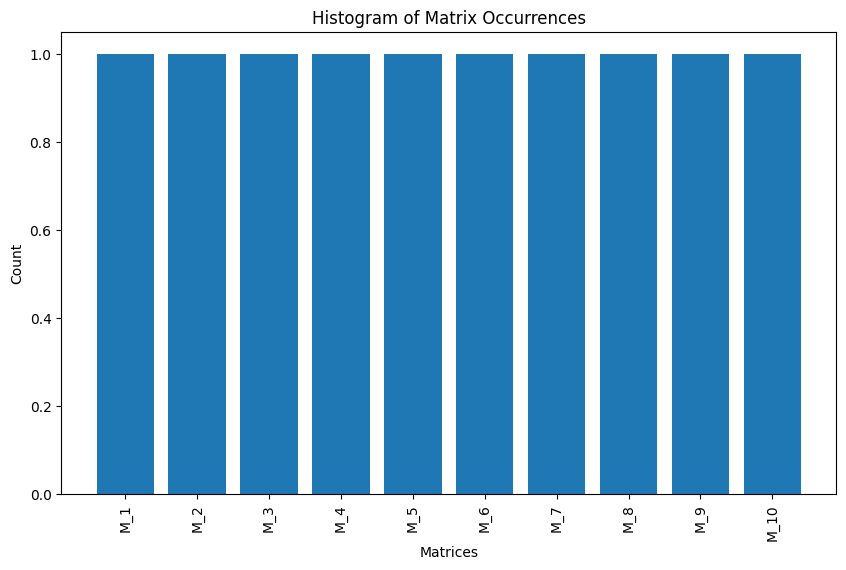

In [184]:
hashable_matrices = [tuple(map(tuple, matrix)) for matrix in thetas]

matrix_counts = Counter(hashable_matrices)

labels, counts = zip(*matrix_counts.items())

labels = [np.array(label) for label in labels]

plt.figure(figsize=(10,6))
plt.bar(range(len(counts)), counts, tick_label=["M_"+str(i+1) for i in range(len(labels))])
plt.xlabel('Matrices')
plt.ylabel('Count')
plt.title('Histogram of Matrix Occurrences')
plt.xticks(rotation=90)
plt.show()